In [1]:
import json
import copy
from tqdm import tqdm

import re
import sys
import json
import math
import warnings
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pyproj import Proj, transform

# ignore weird warnings from pyproj
warnings.filterwarnings('ignore')

# shorcuts
cos = math.cos
sin = math.sin
acos = math.acos
asin = math.asin
degrees = math.degrees
radians = math.radians

# constants
EARTH_RADIUS = 6371000
PI = math.pi

# EP1 - Modelagem de MRU em rodovias
Nesse EP vamos investigar trechos de rodovias utilizando o KartaView

## Passo 1 - Obtendo os dados
Escolhemos um trecho de uma  rodovia no Brasil e outro trecho de uma rodovia no Chile. 

O trecho na rodovia brasileira trata-se da Rodovia Pres. Castelo Branco do Km 24 até o Km 19, cujo id inicial da foto é 5865 e o final é 6160.

O trecho da rodovia no Chile trata-se da Rodovia Ruta 5 do Km 15 ao Km 43, cujo id inicial da foto é 529 e o final é 1390.

Nesses dois trechos há um pedágio, portanto devemos esperar que haja uma redução de velocidade em algum ponto do trajeto.

Ao fazermos as requisições no PostMan obtemos os arquivos json responseBrasil.json e responseChile.json

In [2]:
urlResponseBrasil = 'data/responseBrasil3.json'
urlResponseChile = 'data/responseChile.json'

with open(urlResponseBrasil, "r") as f:
    pontosBrasil = f.read()
    pontosBrasil = json.loads(pontosBrasil)

with open(urlResponseChile, "r") as f:
    pontosChile = f.read()
    pontosChile = json.loads(pontosChile)

idInicialBrasil = 5865
idFinalBrasil = 6160

idInicialChile = 529
idFinalChile = 1390

Esses arquivos possuem muitos dados desnecessários, para isso vamos realizar uma filtragem.

## Passo 2 - Limpando os JSON

Queremos retirar as sequintes colunas de cada "photo": 'lat', 'lng', 'heading', 'shot_data', 'shot_date', 'sequence_index', 'sequence_id'. Para isso, definimos as seguintes funções auxiliares:

In [3]:
def extrairPhotos(pontos):
    pontosExtraido = {'photos': ''}
    pontosExtraido['photos'] = pontos['osv']['photos']
    return pontosExtraido

def limparPontosExtraido(pontosExtraido, wanted):

    unwanted = set(pontosExtraido['photos'][0].keys()) - set(wanted)
    
    for photo in pontosExtraido['photos']:
        for unwanted_key in unwanted: del photo[unwanted_key]
    return pontosExtraido

def filtrarPontosLimpos(pontosLimpo, indiceInicial, indiceFinal):
    pontosLimpo['photos'] = [pontosLimpo['photos'][i] for i in range (indiceInicial, indiceFinal + 1)]
    return pontosLimpo

Agora, filtramos os arquivos e salvamos com nome "rodoviaBrasil.json" e "rodoviaChile.json"

In [4]:
arquivoJsonFinalBrasil = 'data/rodoviaBrasil.json'
arquivoJsonFinalChile = 'data/rodoviaChile.json'

wanted = ['lat', 'lng', 'heading', 'shot_data', 'shot_date', 'sequence_index', 'sequence_id']

pontosExtraidoBrasil = extrairPhotos(pontosBrasil)
pontosLimpoBrasil = limparPontosExtraido(pontosExtraidoBrasil, wanted)
pontosFiltradoBrasil = filtrarPontosLimpos(pontosLimpoBrasil.copy(), idInicialBrasil, idFinalBrasil)

pontosExtraidoChile = extrairPhotos(pontosChile)
pontosLimpoChile = limparPontosExtraido(pontosExtraidoChile, wanted)
pontosFiltradoChile = filtrarPontosLimpos(pontosLimpoChile.copy(), idInicialChile, idFinalChile)

with open(arquivoJsonFinalBrasil, 'w') as f:
    json.dump(pontosFiltradoBrasil, f)
    
with open(arquivoJsonFinalChile, 'w') as f:
    json.dump(pontosFiltradoChile, f)

In [5]:
dataBrasilFiltadro =  pontosFiltradoBrasil['photos']
dataChileFiltadro = pontosFiltradoChile['photos']

dataBrasil = dataBrasilFiltadro
dataChile = dataChileFiltadro

for point in dataBrasil:
    point["lat"] = float(point["lat"])
    point["lng"] = float(point["lng"])

for point in dataChile:
    point["lat"] = float(point["lat"])
    point["lng"] = float(point["lng"])


## Passo 3 - Modelos para o planeta

### 3.1 Trignometria Esférica
Podemos calcular a distância entre dois pontos com coordenadas em latitude e longitude usando trigonometria esférica. podemos fazer isso calculando a distância angular entre esses dois pontos. Sendo $p_1 = (\phi_1, \lambda_1)$ e $p_2 = (\phi_2, \lambda_2)$  dois pontos com coordenadas em latitude e longitude. Temos que a distância angular $C$ entre eles é:

$$C = \sin(\phi_1)\sin(\phi_2) + \cos(\lambda_2 - \lambda_1) \cos(\phi_1) \cos(\phi_2)$$

Assim, a distância em unidade métrica, considerando uma esfera de raio $r$, entre $p_1$ e $p_2$ é:

$$d = r \arccos(C)$$

O cálculo da distância angular está implementado em ``` get_angular_distance ``` e o cálculo da distância em unidade métrica está implementado em ``` get_dist_spherical_trigonometry```:

In [6]:
def get_angular_distance(a, b):
    latA = a["lat"]
    latB = b["lat"]
    lngA = a["lng"]
    lngB = b["lng"]

    # for didatic purposes, I will calculate the
    # angle's complement. But this is not necessary,
    # since cos(x) = sin(90 - x). I did this to make
    # it easier for reading the formula

    # point C is north pole (could be south pole too,
    # it doesn't matter)
    AC = radians(90 - latA)
    BC = radians(90 - latB)
    gamma = radians(abs(lngA - lngB))

    cosAB = cos(AC) * cos(BC) + sin(AC) * sin(BC) * cos(gamma)
    AB = acos(cosAB)
    return AB

def get_dist_spherical_trigonometry(a, b):
    return EARTH_RADIUS * get_angular_distance(a, b)

### 3.2 Haversine
Nesse modelo, iremos considerar a terra uma esfera perfeita. Assim, a fórmula de haversine permite calcularmos a distância $d$ na superfície de uma esfera de raio $r$.

Sejam dois pontos cujas coordenadas (em latitude e longitude) são $p_1 = (\phi_1, \lambda_1)$ e $p_2 = (\phi_2, \lambda_2)$. De acordo com a fórmula a distância $d$ é dada por:

$$d = 2r\arcsin(\sqrt{\sin^2(\frac{\phi_2 - \phi_1}{2}) + \cos{\phi_1} \cos{\phi_2} \sin^{2}(\frac{\lambda_2 - \lambda_1}{2})})$$

Essa fórmula está implementada no código abaixo:

In [7]:
def haversine(a, b):
    latA = radians(a["lat"])
    latB = radians(b["lat"])
    lngA = radians(a["lng"])
    lngB = radians(b["lng"])
    return sin((latA - latB)/2)**2 + cos(latA) * cos(latB)* (sin((lngA - lngB)/2)**2)

def get_dist_haversine(a, b):
    s = haversine(a, b)
    return 2 * EARTH_RADIUS * asin(s**(1/2))

### 3.3 Projeção de Mercator
Vamos calcular a distância entra cada par de pontos consecutivos usando a projeção de Mercator. Para isso, fazemos uso da biblioteca ```pyproj```, a qual projeta as coordenadas esféricas em um plano utlizando a projeção de Mercator. Isso está implementado na função ```get_point_coords_proj```.

Depois, calculamos a distância euclidiana entre essas projeções usando a função ``` get_dist_proj```.

In [8]:
def get_point_coords_proj(a):
    lat = a['lat']
    lng = a['lng']
    p = np.array((lng, lat))
    return transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), p[0], p[1])

def get_dist_proj(a, b):
    pa = get_point_coords_proj(a)
    pb = get_point_coords_proj(b)
    return ((pa[0] - pb[0])**2 + (pa[1] - pb[1])**2)**(1/2)

## Passo 4 - Calculo de Distâncias

Vamos agora calcular a distância total percorrida em cada trecho e a distância entre par de pontos consecutivos usando cada um dos modelos acima. Fazemos isso iterando sobre o dataset.

In [9]:
LBrasil = len(dataBrasil)
lBrasil = LBrasil - 1
indexes0lBrasil = range(0, lBrasil)
indexes1LBrasil = range(1, LBrasil)
indexes0LBrasil = range(0, LBrasil)
                                       #variáveis usadas em loops
LChile = len(dataChile)
lChile = LChile - 1
indexes0lChile = range(0, lChile)
indexes1LChile = range(1, LChile)
indexes0LChile = range(0, LChile)

### 4.1 Cálculo da distância entre pontos consecutivos

In [10]:
## CONSECUTIVE DISTANCE
dist_projBrasil = []
dist_trigBrasil = []
dist_havBrasil = []

dist_projChile = []
dist_trigChile = []
dist_havChile = []

for i in tqdm(range(0, len(dataBrasil) - 1)):
    a = dataBrasil[i]
    b = dataBrasil[i + 1]
    dist_projBrasil.append(get_dist_proj(a, b))
    dist_havBrasil.append(get_dist_haversine(a, b))
    dist_trigBrasil.append(get_dist_spherical_trigonometry(a, b))

for i in tqdm(range(0, len(dataChile) - 1)):
    a = dataChile[i]
    b = dataChile[i + 1]
    dist_projChile.append(get_dist_proj(a, b))
    dist_havChile.append(get_dist_haversine(a, b))
    dist_trigChile.append(get_dist_spherical_trigonometry(a, b))

100%|██████████| 861/861 [03:36<00:00,  3.98it/s]


### 4.2 Cálculo da distância total até certo ponto

In [11]:
## TOTAL DISTANCE
dist_proj_acBrasil = []
dist_trig_acBrasil = []
dist_hav_acBrasil = []

dist_proj_acChile = []
dist_trig_acChile = [] 
dist_hav_acChile = []

dTotalBrasil = 0
dTotalChile = 0

for i in tqdm(range(len(dist_projBrasil))):
    if(i == 0):
        dist_proj_acBrasil.append(dist_projBrasil[i])
        dist_hav_acBrasil.append(dist_havBrasil[i])
        dist_trig_acBrasil.append(dist_trigBrasil[i])
    
    else:
        dist_proj_acBrasil.append(dist_proj_acBrasil[i-1] + dist_projBrasil[i])
        dist_hav_acBrasil.append(dist_hav_acBrasil[i-1] + dist_havBrasil[i])
        dist_trig_acBrasil.append(dist_trig_acBrasil[i-1] + dist_trigBrasil[i])

for i in tqdm(range(len(dist_projChile))):
    if(i == 0):
        dist_proj_acChile.append(dist_projChile[i])
        dist_hav_acChile.append(dist_havChile[i])
        dist_trig_acChile.append(dist_trigChile[i])
    
    else:
        dist_proj_acChile.append(dist_proj_acChile[i-1] + dist_projChile[i])
        dist_hav_acChile.append(dist_hav_acChile[i-1] + dist_havChile[i])
        dist_trig_acChile.append(dist_trig_acChile[i-1] + dist_trigChile[i])   

100%|██████████| 861/861 [00:00<00:00, 278262.89it/s]


## Passo 5 - Cálculo de Tempos e Velocidades
Vamos calcular o tempo decorrido e a velocidade entre dois pontos do subtrecho. Convertemos o valor de ```shot_date``` para uma estrutura de dados de tempo para ficar mais fácil de lidarmos com variação de tempo. Depois, salvamos o valor do intervalo em segundos no vetor ```timesBrasil``` ou ```timesChile```.

### 5.1 Tempo entre dois pontos consecutivos

In [12]:
timesBrasil = []
timesChile = []
FMT = '%Y-%m-%d %H:%M:%S'
for d in dataBrasil:
    # convert string time to date object
    d["time"] = datetime.strptime(d["shot_date"], FMT)

for d in dataChile:
    # convert string time to date object
    d["time"] = datetime.strptime(d["shot_date"], FMT)

for i in tqdm(range(0, len(dataBrasil) -1)):
    timesBrasil.append((dataBrasil[i+1]["time"] - dataBrasil[i]["time"]).seconds)
    
    
for i in tqdm(range(0, len(dataChile) - 1)):
    # calculate time difference
    timesChile.append((dataChile[i + 1]["time"] - dataChile[i]["time"]).seconds)

100%|██████████| 861/861 [00:00<00:00, 116726.86it/s]


### 5.2 Velocidade entre dois pontos consecutivos
Agora, de posse do intervalo de tempo entre duas fotos consecutivas e a distância (Mercartor, pyproj ou haversine), podemos calcular a velocidade média entre cada par de pontos consecutivos.

In [13]:
## INSTANT SPEED
v_projBrasil = []
v_trigBrasil = []
v_havBrasil = []

v_projChile = []
v_trigChile = []
v_havChile = []

for i in tqdm(range(len(dist_projBrasil))):
    tdelta = timesBrasil[i]
    if(tdelta == 0):
        tdelta = 0.00001
    v_projBrasil.append(dist_projBrasil[i]/tdelta)
    v_trigBrasil.append(dist_trigBrasil[i]/tdelta)
    v_havBrasil.append(dist_havBrasil[i]/tdelta)
    
for i in tqdm(indexes0lChile):
    tdelta = timesChile[i]
    v_projChile.append(dist_projChile[i]/tdelta)
    v_trigChile.append(dist_trigChile[i]/tdelta)
    v_havChile.append(dist_havChile[i]/tdelta)

100%|██████████| 861/861 [00:00<00:00, 374965.81it/s]


## Passo 6 - Plotar Resultados
Vamos utlizar a biblioteca ```matplotlib``` para visualizar os resultados. Para isso definimos as seguintes funções abaixo:

In [223]:
# single plot
def plot(x, y, title, xlabel, ylabel, label):
    plt.plot(x, y, label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc = "upper left")
    plt.show()

# get list average
def get_average(lst):
    sum = 0
    for i in range(0, len(lst)):
        sum += lst[i]
    return sum / len(lst)

# multiple plots together
def plots(x, ys, title, xlab, ylab, labels, vLineIndex, averageLine, local = "upper left"):
    l = len(ys)
    # generate single plot for each dataset
    ##for i in range(0, l):
      ##  plot(x, ys[i], title, xlab, ylab, labels[i])
    colrs = ["#1f77b4", "#ff7f0e", "#2ca02c"]
    # plot all datasets together
    for i in range(0, l):
        plt.plot(x, ys[i], 'o', label = labels[i], markersize=5)
        if averageLine:
            plt.hlines(y = get_average(ys[i]), xmin = x[0], xmax = x[len(x) -1], 
               colors = colrs[i], 
               linestyles = 'dashed',
               label = "V. Média " + labels[i])
    if vLineIndex > -1:
        plt.vlines(x = vLineIndex, ymin = 0, ymax = max(ys[0]), 
           colors = 'black', 
           linestyles = 'dashed',
           label = 'Ponto de parada') 
     
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.title(title)
    plt.legend(loc = local, bbox_to_anchor=(1, 0.5))
    plt.show()

In [224]:
v_ysChile = [v_projChile, v_havChile, v_trigChile]
dist_ysChile = [dist_projChile, dist_havChile, dist_trigChile]
dist_ac_ysChile = [dist_proj_acChile, dist_hav_acChile, dist_trig_acChile]

v_ysBrasil = [v_projBrasil, v_havBrasil, v_trigBrasil]
dist_ysBrasil = [dist_projBrasil, dist_havBrasil, dist_trigBrasil]
dist_ac_ysBrasil = [dist_proj_acBrasil, dist_hav_acBrasil, dist_trig_acBrasil]

labels = [
    "Método da projeção",
    "Método da fórmula de Haversine",
    "Método da trigonometria esférica"]


### 6.1 Tempo decorrido entre dois pontos consecutivos

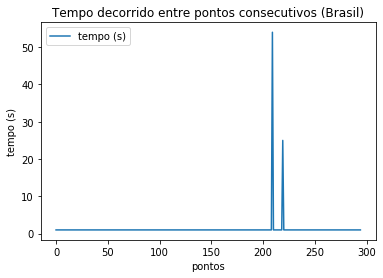

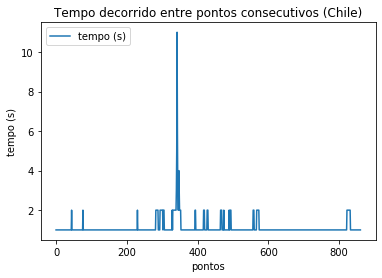

In [225]:
# plot time difference
x = indexes0lBrasil
y = timesBrasil
title = "Tempo decorrido entre pontos consecutivos (Brasil)"
xlab = "pontos"
ylab = "tempo (s)"
plot(x, y, title, xlab, ylab, ylab)

x = indexes0lChile
y = timesChile
title = "Tempo decorrido entre pontos consecutivos (Chile)"
xlab = "pontos"
ylab = "tempo (s)"
plot(x, y, title, xlab, ylab, ylab)

### 6.2 Velocidade Média entre pontos consecutivos

Há uma linha vertical indicando onde há um parada do carro

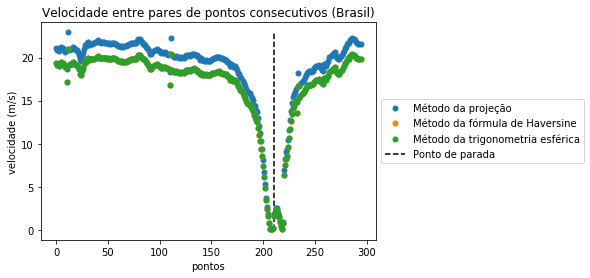

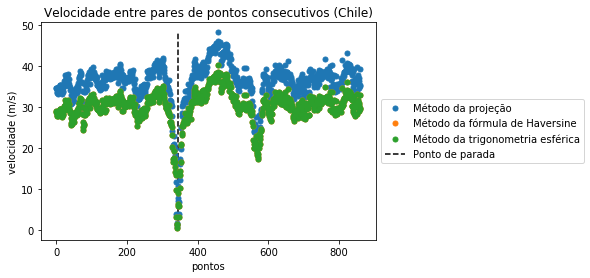

In [226]:
x = indexes0lBrasil
title = "Velocidade entre pares de pontos consecutivos (Brasil)"
ylab = "velocidade (m/s)"
xlab = "pontos"
plots(x, v_ysBrasil, title, xlab, ylab, labels, 210, False, local = "center left")

x = indexes0lChile
title = "Velocidade entre pares de pontos consecutivos (Chile)"
ylab = "velocidade (m/s)"
xlab = "pontos"
plots(x, v_ysChile, title, xlab, ylab, labels, 345, False, local = "center left")



### 6.3 Distância percorrida entre dois pontos consecutivos

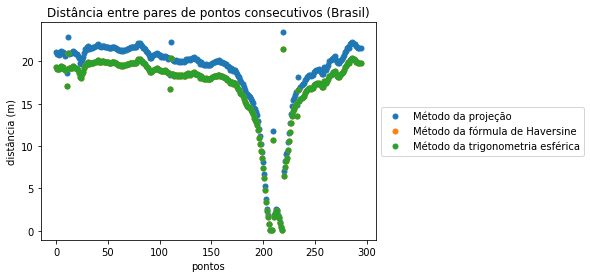

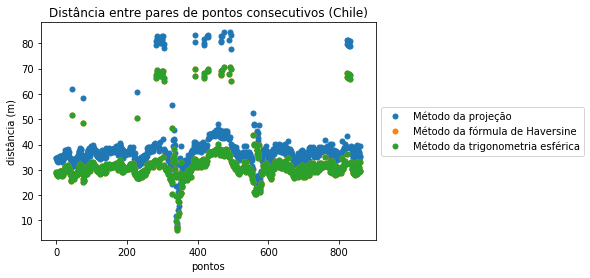

In [227]:
# plot consecutive distances
x = indexes0lBrasil
title = "Distância entre pares de pontos consecutivos (Brasil)"
ylab = "distância (m)"
plots(x, dist_ysBrasil, title, xlab, ylab, labels, -1, False, local = "center left")

x = indexes0lChile
title = "Distância entre pares de pontos consecutivos (Chile)"
ylab = "distância (m)"
plots(x, dist_ysChile, title, xlab, ylab, labels, -1, False, local = "center left")

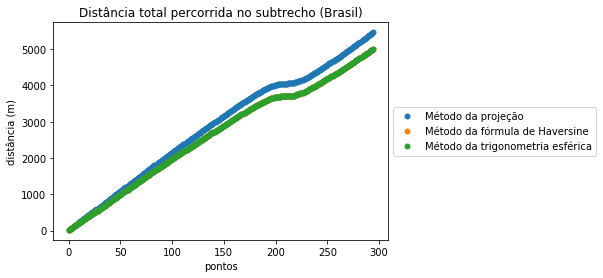

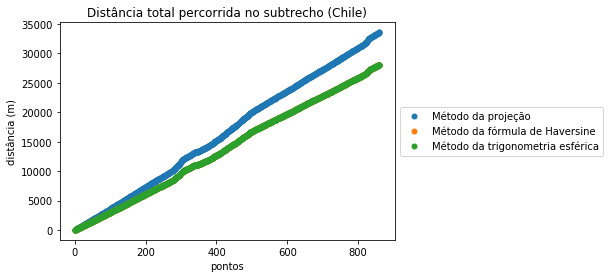

In [228]:
x = indexes0lBrasil
title = "Distância total percorrida no subtrecho (Brasil)"
ylab = "distância (m)"
plots(x, dist_ac_ysBrasil, title, xlab, ylab, labels, -1, False, local = "center left")

x = indexes0lChile
title = "Distância total percorrida no subtrecho (Chile)"
ylab = "distância (m)"
plots(x, dist_ac_ysChile, title, xlab, ylab, labels, -1, False, local = "center left")



## 6.4 Velocidade Constante em Trechos entre uma Parada

Ao observarmos os dois gráficos de velocidade, vemos que há dois trechos em que a velocidade é aproximadamente constante e, ou seja, em que o carro está em MRU. Há também, quase no centro dos gráficos da velocidade, uma pequeno intervalo de ponntos em que a velocidade é quase nula, o que indica uma parada.

Temos nos gráficos dos dois MRU relatados nos dois trechos. Na rodovia brasileira, temos:

-A primeira velocidade constante no intervalo [50, 100];

-A segunda velocidade constante no intervalo [230, 280];

Na rodovia chilena, temos:

-A primeira velocidade constante no intervalo [50, 100];

-A segunda velocidade constante no intervalo [700, 750];

working


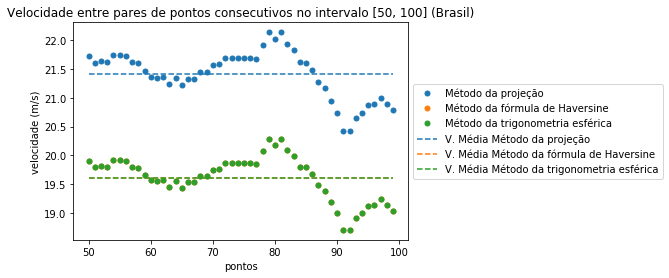

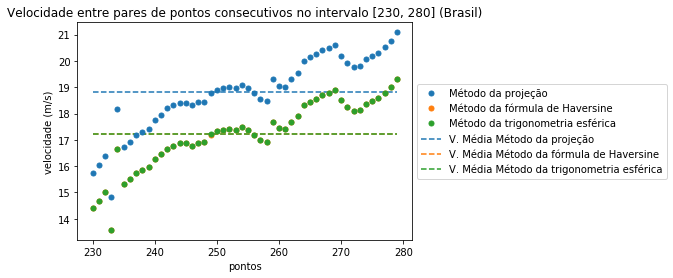

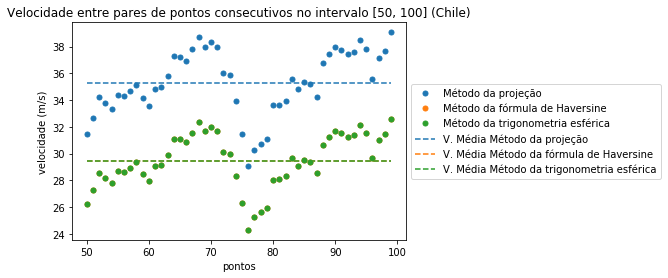

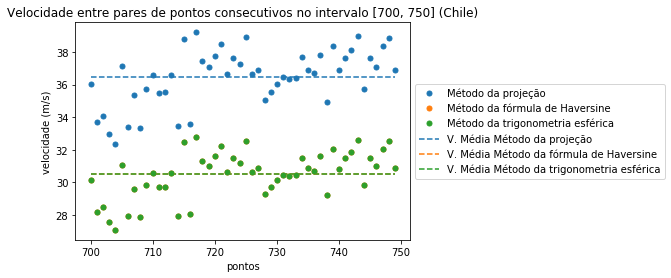

In [229]:
def get_sublists(init, fim, lists):
    sublists = []
    for i in range(0, 3):
        aux = lists[i]
        lst = []
        for j in range(init, fim):
            point = aux[j]
            lst.append(point)
        sublists.append(lst)
    return sublists

print("working")

#brasil [50-100]:
x = range(50, 100)
v_interv_brasil = get_sublists(50, 100, v_ysBrasil)
title = "Velocidade entre pares de pontos consecutivos no intervalo [50, 100] (Brasil)"
ylab = "velocidade (m/s)"
xlab = "pontos"
plots(x, v_interv_brasil, title, xlab, ylab, labels, -1, True, local = "center left")

#brasil [230, 280]
x = range(230, 280)
v_interv_brasil = get_sublists(230, 280, v_ysBrasil)
title = "Velocidade entre pares de pontos consecutivos no intervalo [230, 280] (Brasil)"
ylab = "velocidade (m/s)"
xlab = "pontos"
plots(x, v_interv_brasil, title, xlab, ylab, labels, -1, True, local = "center left")

#chile [50, 100]
x = range(50, 100)
v_interv_chile = get_sublists(50, 100, v_ysChile)
title = "Velocidade entre pares de pontos consecutivos no intervalo [50, 100] (Chile)"
ylab = "velocidade (m/s)"
xlab = "pontos"
plots(x, v_interv_chile, title, xlab, ylab, labels,-1, True, local = "center left")

#chile [700, 750]
x = range(700, 750)
v_interv_chile = get_sublists(700, 750, v_ysChile)
title = "Velocidade entre pares de pontos consecutivos no intervalo [700, 750] (Chile)"
ylab = "velocidade (m/s)"
xlab = "pontos"
plots(x, v_interv_chile, title, xlab, ylab, labels, -1, True, local = "center left")
